
# CoNi 16 Dataset Cropping

### Indices of the BSE crop:

***Original shape: $(2048, 3072)$***

    - X (columns)
        - Total crop width: dx = 2220 
        - slice(476, 2696)
    - Y (rows)
        - Total crop height: dy = 1665
        - slice(175, 1840)

Once this crop is complete, a resize transform was applied through ***scikit-image*** to get to a target size of $(483, 644)$

### Indices of the EBSD crop:

***Original shape: $(484,654)$***

    - X (columns)
        - Total crop width: dx = 644
        - slice(10, None)
    - Y (rows)
        - Total crop height: dy = 483
        - slice(None, -1)


___
___

# Spalled AM Ta Dataset Cropping

### Indices of the BSE crop:

***Original shape: $(4092, 6144)$***

    - X (columns)
        - Total crop width: dx = 4212
        - slice(1066, 5278)
    - Y (rows)
        - Total crop height: dy = 4050
        - slice(0, 4050)

Once this crop is complete, a resize transform was applied through ***scikit-image*** to get to a target size of $(675, 702)$

### Indices of the EBSD crop:

***Original shape: $(689,709)$***

    - X (columns)
        - Total crop width: dx = 702
        - slice(7, None)
    - Y (rows)
        - Total crop height: dy = 675
        - slice(None, 675)


___
___

# CoNi TFS (90° interlayer rotation) Dataset

### Indices of the BSE crop:

***Original shape: $(1180, 2416)$***

    - X (columns)
        - Total crop width: dx = 2025
        - slice(195, 2220)
    - Y (rows)
        - Total crop height: dy = 972
        - slice(104, 1076)

Once this crop is complete, a resize transform was applied through ***scikit-image*** to get to a target size of $()$

### Indices of the EBSD crop:

***Original shape: $(535,1109)$***

    - X (columns)
        - Total crop width: dx = 1100
        - slice(9, None)
    - Y (rows)
        - Total crop height: dy = 528
        - slice(None, 528)


___
___

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as ani
import h5py
import imageio
from skimage import io, transform, exposure, morphology, measure
from rich.progress import track
%matplotlib widget

import core

def generate_gif(array, savename):
    fig = plt.figure()
    im = plt.imshow(array[0, :, :],
                    animated=True,
                    cmap='cividis',
                    vmin=array.min(),
                    vmax=array.max())
    def init():
        im.set_data(array[0, :, :])
        return im,
    def animate(i):
        im.set_array(array[i, :, :])
        return im,
    anim = ani.FuncAnimation(fig,
                             animate,
                             init_func=init,
                             frames=array.shape[0],
                             interval=1,
                             blit=True)
    anim.save(f"{savename}.gif")
    plt.close()


def get_slice(dx, dy):
    # get slice for x axis
    if dx > 0:
        sliceROW_c = slice(0, -dx, None)
        sliceROW_p = slice(dx, None, None)
    elif dx == 0:
        sliceROW_c = slice(None, None, None)
        sliceROW_p = slice(None, None, None)
    else:
        sliceROW_c = slice(-dx, None, None)
        sliceROW_p = slice(0, dx, None)
    # get slice for y axis
    if dy > 0:
        sliceCOL_c = slice(0, -dy, None)
        sliceCOL_p = slice(dy, None, None)
    elif dy == 0:
        sliceCOL_c = slice(None, None, None)
        sliceCOL_p = slice(None, None, None)
    else:
        sliceCOL_c = slice(-dy, None, None)
        sliceCOL_p = slice(0, dy, None)
    # combine x and y slices and return
    current = (
        sliceROW_c,
        sliceCOL_c,
    )
    previous = (
        sliceROW_p,
        sliceCOL_p,
    )
    return (current, previous)

In [2]:
def get_difference(bse, ebsd, x, y):
    if type(x) == tuple:
        ebsd_x = x[0]
        bse_x = x[1]
    else:
        ebsd_x = x
        bse_x = x
    if type(y) == tuple:
        ebsd_y = y[0]
        bse_y = y[1]
    else:
        ebsd_y = y
        bse_y = y
    bse_row_slice = bse[:, bse_y, :]
    bse_col_slice = bse[:, :, bse_x]
    bse_row_slice = morphology.remove_small_holes(bse_row_slice, area_threshold=10000)
    bse_row_slice = morphology.binary_closing(bse_row_slice)[:, :200]
    bse_col_slice = morphology.remove_small_holes(bse_col_slice, area_threshold=10000)
    bse_col_slice = morphology.binary_closing(bse_col_slice)[:, :200]
    bse_locs = np.array(list(zip(bse_row_slice.argmax(axis=1), bse_col_slice.argmax(axis=1))))

    ebsd_row_slice = ebsd[:, ebsd_y, :]
    ebsd_col_slice = ebsd[:, :, ebsd_x]
    ebsd_row_slice = morphology.remove_small_holes(ebsd_row_slice, area_threshold=10000)
    ebsd_row_slice = morphology.binary_closing(ebsd_row_slice)[:, :200]
    ebsd_col_slice = morphology.remove_small_holes(ebsd_col_slice, area_threshold=10000)
    ebsd_col_slice = morphology.binary_closing(ebsd_col_slice)[:, :200]
    ebsd_locs = np.array(list(zip(ebsd_row_slice.argmax(axis=1), ebsd_col_slice.argmax(axis=1))))

    diff = bse_locs - ebsd_locs
    print(diff.shape)
    diff[:, 1] = 0
    return diff

def apply_shifts(shifts, array):
    new_array = np.zeros(array.shape, dtype=array.dtype)
    for i in range(array.shape[0]):
        old_slc, new_slc = get_slice(shifts[i,1], shifts[i,0])
        new_array[i][new_slc] = array[i][old_slc]
    return new_array


def pick_row_col(s0:np.ndarray, s1:np.ndarray, row:tuple | int, col: tuple | int, z: int=0) -> None:
    plt.close("all")
    fig = plt.figure(figsize=(12,4))
    ax1 = fig.add_subplot(121)
    ax1.imshow(s0[z])
    ax1.axvline(col[0])
    ax1.axhline(row[0])
    ax2 = fig.add_subplot(122)
    ax2.imshow(s1[z])
    ax2.axvline(col[1])
    ax2.axhline(row[1])
    plt.show()

In [4]:
h5 = h5py.File("D:/Research/NiAlMo_APS/Data/3D/NiAlMo_basic.dream3d", 'r')
data = h5["DataContainers/ImageDataContainer/CellData/Confidence Index"][:,:,:,0]
h5.close()
# ebsd_slice_x = slice(10, None)
# ebsd_slice_y = slice(None, -1)
# ebsd = data[:, ebsd_slice_y, ebsd_slice_x]
ebsd = data
print(ebsd.shape)

(391, 781, 1101)


### Get Data

In [3]:
# Get ebsd data
h5 = h5py.File("D:/Research/CoNi_16/Data/3D/CoNi16_aligned.dream3d", 'r+')
s = "DataContainers/ImageDataContainer/CellData/"
# EBSD crop taken care of in h5 already
# ebsd_slice_x = slice(10, None)
# ebsd_slice_y = slice(None, -1)
ebsd = h5[s+"Mask"][:,:,:,0]
print(ebsd.shape)

(460, 484, 654)


In [43]:
s = 22
bse_slice_y = slice(104, 1180-104)
bse_slice_x = slice(195, 2416-196)
ebsd_slice_y = slice(None, 528)
ebsd_slice_x = slice(9, None)
# Get bse data
bse_folder = "D:/Research/CoNi_TFS/Data/3D/BSE/"
paths = sorted([path for path in os.listdir(bse_folder) if ".tif" in path], key=lambda x: int(x.replace(".tif","")))
bse_imgs_raw = np.array([io.imread(bse_folder+path, as_gray=True) for path in paths])
bse_imgs = bse_imgs_raw[:, bse_slice_y, bse_slice_x]
# Get EBSD
h5 = h5py.File("D:/Research/CoNi_TFS/Data/3D/CoNi90_basic.dream3d", 'r')
cs = "DataContainers/ImageDataContainer/CellData/"
ebsd = np.squeeze(h5[cs + "CI"][...])
# Transform to correct size
bse_imgs_small = np.zeros(ebsd.shape)
for i in range(bse_imgs_small.shape[0]):
    if i < 7:
        im = transform.resize(bse_imgs[0], ebsd[0].shape, anti_aliasing=True)
    else:
        im = transform.resize(bse_imgs[i - 7], ebsd[0].shape, anti_aliasing=True)
    im = np.around(255*im/im.max(), 0).astype(np.uint8)
    imageio.imsave(f"D:/Research/CoNi_TFS/Data/3D/BSE/small/{i}.tiff", im)
    bse_imgs_small[i] = im


In [7]:
# Get bse data
bse_folder = "D:/Research/NiAlMo_APS/Data/All_BSE_resized/"
paths = sorted([path for path in os.listdir(bse_folder) if ".tif" in path], key=lambda x: int(x.replace(".tif","").replace("aligned_","")))
bse_imgs_small = np.array([io.imread(bse_folder+path, as_gray=True) for path in paths])
print(bse_imgs_small.shape)
#for i in range(bse_imgs_small.shape[0]):
#    imageio.imsave(f"D:/Research/CoNi_TFS/Data/3D/BSE/small/{i}.tiff", bse_imgs_small[i, ::-1, ::-1])

(391, 781, 1101)


### Correct BSE data

In [8]:
mask = np.where(bse_imgs_small > bse_imgs_small.mean() * 0.85, True, False)
# Created filled mask
mask_filled = np.zeros(mask.shape)
for i in range(mask.shape[0]):
    im = morphology.remove_small_holes(mask[i], area_threshold=10000)
    im = morphology.remove_small_objects(im, min_size=200000)
    mask_filled[i] = im
mask_filled = mask_filled

In [19]:
data = np.where(ebsd > 0.22, 1, 0)
data = morphology.remove_small_holes(data, area_threshold=10000)
data = morphology.binary_erosion(data, np.ones((5,5,5)))
data = morphology.remove_small_objects(data, min_size=500000)
data = morphology.binary_dilation(data, np.ones((5,5,5)))

c:\Users\lambj\miniconda3\envs\align\lib\site-packages\skimage\_shared\utils.py:157: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  return func(*args, **kwargs)


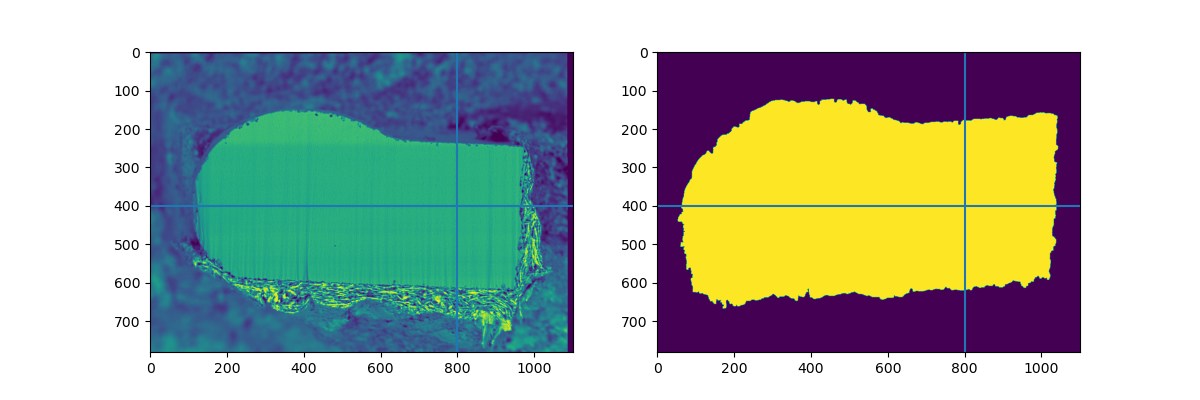

In [26]:
pick_row_col(bse_imgs_small, data, (400, 400), (800, 800), 160)

### Correct EBSD data

In [34]:
x = (800, 800)      # Columns
y = (400, 400)      # Rows

s0 = data    # The one to be shifted
s1 = mask_filled     # The reference
s_altered = s0
difference = 1000
iteration = 0
diffs = []
verbose = True
while np.abs(difference) > 1 and iteration < 20:
    diff_run = get_difference(s1.astype(bool), s_altered.astype(bool), x[0], y[0])
    diffs.append(diff_run)
    s_altered = apply_shifts(diff_run, s_altered)
    difference = diff_run.sum()
    if verbose:
        print(f"{difference} on iteration {iteration}")
    iteration += 1

diff_total = np.array(diffs).sum(axis=0)
# diff_total[:, 0] += 10 

(391, 2)
25181 on iteration 0
(391, 2)
-12 on iteration 1
(391, 2)
7 on iteration 2
(391, 2)
8 on iteration 3
(391, 2)
9 on iteration 4
(391, 2)
11 on iteration 5
(391, 2)
12 on iteration 6
(391, 2)
12 on iteration 7
(391, 2)
12 on iteration 8
(391, 2)
12 on iteration 9
(391, 2)
12 on iteration 10
(391, 2)
12 on iteration 11
(391, 2)
12 on iteration 12
(391, 2)
12 on iteration 13
(391, 2)
12 on iteration 14
(391, 2)
12 on iteration 15
(391, 2)
12 on iteration 16
(391, 2)
12 on iteration 17
(391, 2)
12 on iteration 18
(391, 2)
13 on iteration 19


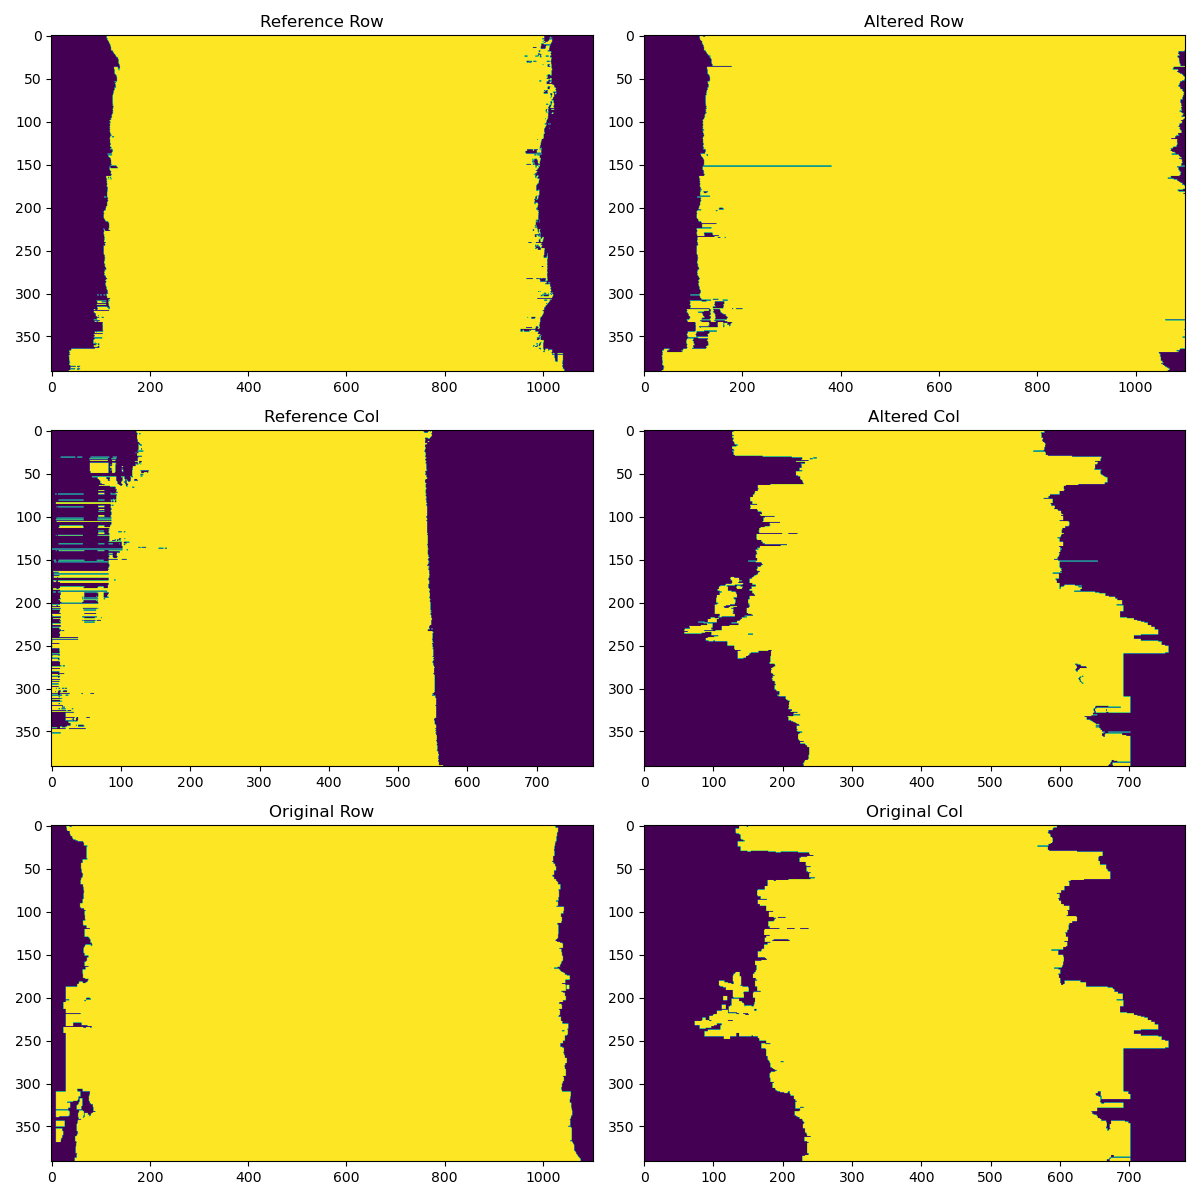

In [35]:
s_new = apply_shifts(diff_total, data)
plt.close(0)
fig = plt.figure(0, figsize=(12,12))
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
ax6 = fig.add_subplot(326)
ax1.set_title("Reference Row")
ax1.imshow(s1[:, y[1], :], aspect="auto")
ax2.set_title("Altered Row")
ax2.imshow(s_new[:, y[0], :], aspect="auto")
ax3.set_title("Reference Col")
ax3.imshow(s1[:, :, x[1]], aspect="auto")
ax4.set_title("Altered Col")
ax4.imshow(s_new[:, :, x[0]], aspect="auto")
ax5.set_title("Original Row")
ax5.imshow(s0[:, y[0], :], aspect="auto")
ax6.set_title("Original Col")
ax6.imshow(s0[:, :, x[0]], aspect="auto")
plt.tight_layout()
plt.show()


### Propogate shifts and write to H5

In [8]:
for key in h5[s].keys():
    data = h5[s+key][...]
    for dim in range(data.shape[-1]):
        data[:,:,:,dim] = apply_shifts(diff_total, data[:,:,:,dim])
    h5[s+key][...] = data
    print(key)

CI
EulerAngles
IPFColor_001
IQH
IQS
Mask
MisColor_001
Phase_mask
Phases
Quats
SEM
Stereo Coords
X
XC
Y
Z


In [9]:
h5.close()
